In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

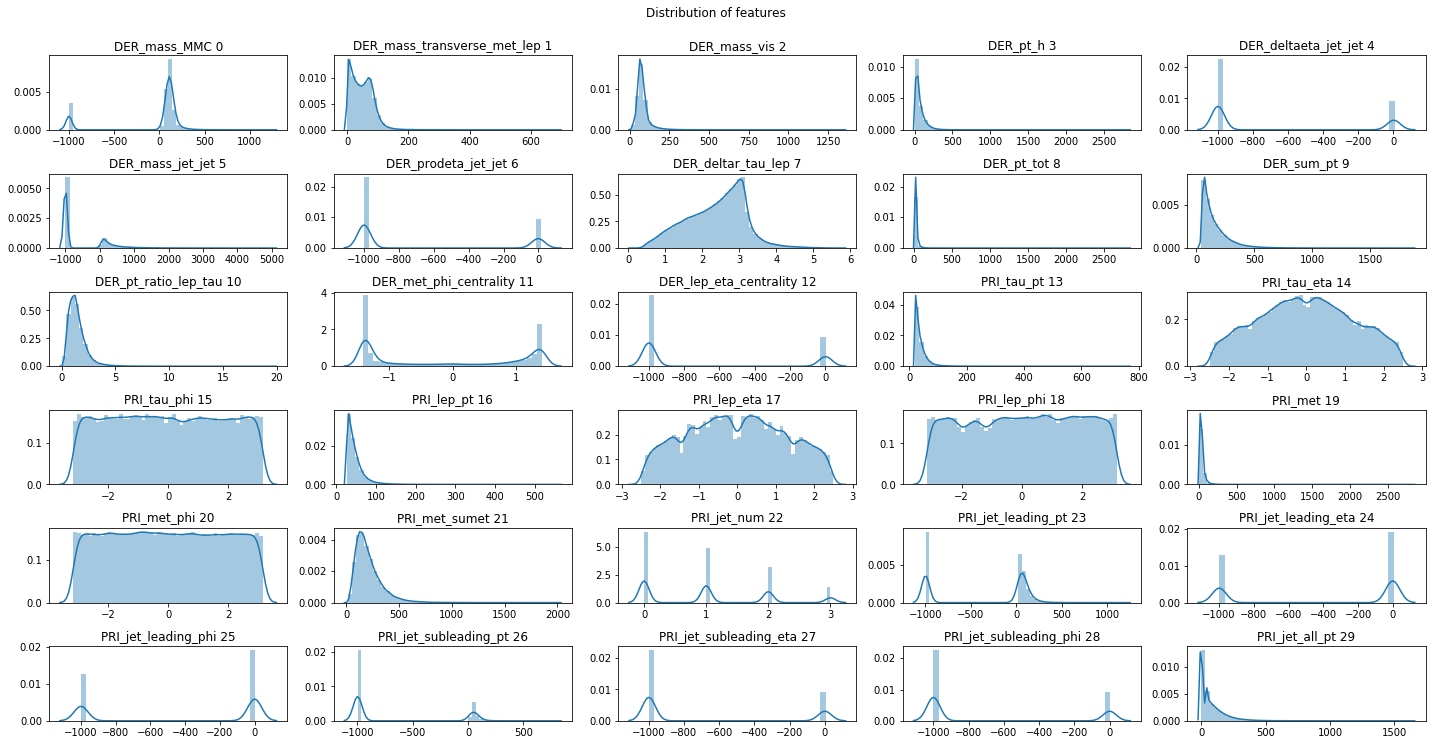

In [3]:
from plots import plot_feature_distribution
plot_feature_distribution(tX, headers, np.arange(len(headers)), "Distribution of features", 5, 6)

As we can see from these plots, different features have different distributions. We can also notice that there seems to be one categorical feature, namely `PRI_jet_num`. This feature is the number of jets used during the experiment. If we look at the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), we can see that some feature are actually affected by the number of jets used.

Features affected by undefined values:
- `DER_mass_MMC` ID=0: undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` ID=4 : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` ID=5: undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` ID=6: undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` ID=12: undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` ID=23: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` ID=24: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` ID=25: undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` ID=26: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` ID=27: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` ID=28: undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution.

For now, we will split the dataset into 6 categories:
- `tX_0, y_0` : Features and labels for experiments with 0 jets, that have a defined `DER_mass_MMC`
- `tX_0_nm,, y_0_nm`:  Features and labels for experiments with 0 jets, that have an undefined `DER_mass_MMC`
- `tX_1, y_1` : Features and labels for experiments with 1 jet, that have a defined `DER_mass_MMC`
- `tX_1_nm, y_1_nm`: Features and labels for experiments with 1 jet, that have an undefined `DER_mass_MMC`
- `tX_2, y_2` : Features and labels for experiments with more than 1 jets
- `tX_2_nm, y_2_nm`: Features and labels for experiments with more than 1 jet, that have an undefined `DER_mass_MMC`



In [4]:
from data_processing import split_dataset

jet_column = 22
mass_col = 0
tX_0, y_0, tX_0_nm, y_0_nm, tX_1, y_1, tX_1_nm, y_1_nm, tX_2, y_2, tX_2_nm, y_2_nm, tX_3, y_3, tX_3_nm, y_3_nm = split_dataset(tX, y, jet_col=jet_column, mass_col=0) # Split into each category

Now that we have split the dataset, we need to select the columns that are meaningful for each category, and add some features using polynomial expansion, exponential, logarithm and so on. For that, we have created a function `enhance_features`. This function adds all the expansions and performs PCA to project the feature matrix on a new basis

In [43]:
from feature_expansion import enhance_features
from data_processing import prepare_for_training
from implementations import reg_logistic_regression, logistic_regression
from cross_validation import cross_validate_lambdas, build_k_indices, cross_validate_degrees

def train_model(x, y, headers, degrees, train_ratio, max_iters, gamma, lambda_):
    x_new, proj_mat = enhance_features(x, headers, degrees, plot=False)
    x_train, y_train, x_test, y_test = prepare_for_training(x_new, y, train_ratio)
    initial_w = np.ones((x_train.shape[1], 1))
    weights, loss = reg_logistic_regression(y_train, x_train, lambda_, initial_w, max_iters, gamma, decay=True)

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Regularized Logistic regression got score of {score}, loss of {loss}")
    return weights, proj_mat

def cross_validate_reg(x, y, headers, gamma, degrees, title):
    x_new, proj_mat = enhance_features(x, headers, degrees, plot=False, print_=False)
    x_train, y_train, x_test, y_test = prepare_for_training(x_new, y, 0, split=False)
    max_iters = 1000
    lambdas = np.logspace(-4, 0, 5)
    accuracies, losses_val = cross_validate_lambdas(y_train, x_train, 4, max_iters, gamma, lambdas)

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    ax[0].plot(np.mean(accuracies, axis=1))
    ax[0].set_xticks(np.arange(len(lambdas)));
    ax[0].set_xticklabels(lambdas);
    ax[0].set_title("Mean validation accuracy")
    ax[0].set_xlabel("Regularization paramter")
    
    ax[1].plot(np.mean(losses_val, axis=1))
    ax[1].set_xticks(np.arange(len(lambdas)));
    ax[1].set_xticklabels(lambdas);
    ax[1].set_title("Mean validation loss")
    ax[1].set_xlabel("Regularization parameter")
    fig.suptitle(title, y=1.05)


### Category 0

First we need to see how polynomial expansion affects the validation accuracy and loss of our models, to select the appropriate degree. We select a learning rate of `1e-5`, and no regularization for now. The function below performs k-fold cross validation on various expansion degrees.

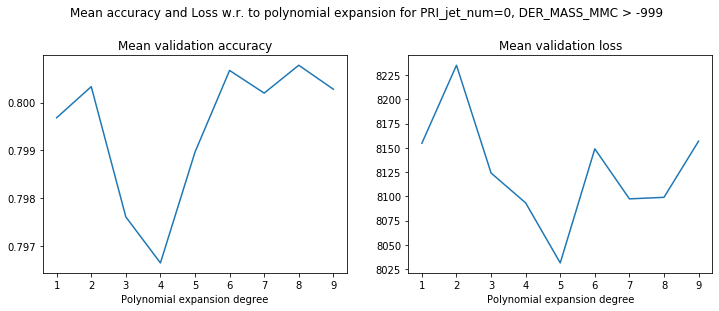

In [6]:
cross_validate_degrees(tX_0, y_0, headers, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC > -999")

In [15]:
degree_0 = 6

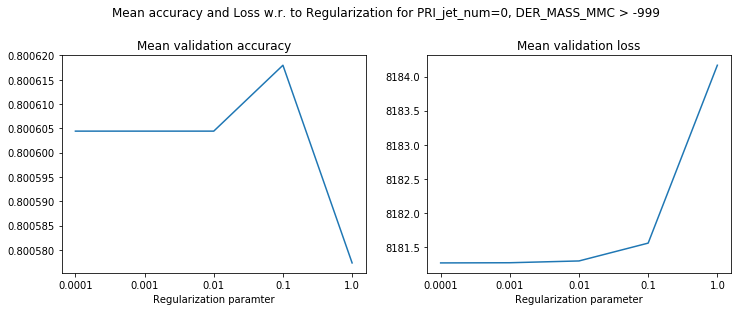

In [44]:
cross_validate_reg(tX_0, y_0, headers, 1e-5, degree_0, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=0, DER_MASS_MMC > -999")

In [148]:
w_0, matrix_0 = train_model(tX_0, y_0, headers, degree_0, 0.9, 1500, 1e-5, 1e-1)

The 18 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet']

Performing polynomial expansion up to degree 6
Matrix has now 18 features
Gradient Descent(0/1499): loss=207353.4414149498
Gradient Descent(100/1499): loss=30628.00174272843
Gradient Descent(200/1499): loss=30260.09812582062
Gradient Descent(300/1499): loss=30115.70871379774
Gradient Descent(400/1499): loss=30105.239993808646
Gradient Descent(500/1499): loss=30096.223826234236
Gradient Descent(600/1499): loss=30087.720568014247
Gradient Descent(700/1499): loss=30086.822994460366
Gradient Descent(800/1499): loss=30086.004416077372
Gradient Descent(900/1499): loss=30085.190461932743
Gradient Descent(1000/1499): loss=30085.1020

### Category 0, no mass defined

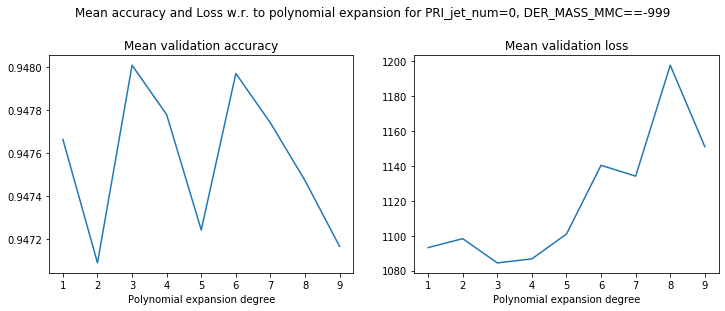

In [47]:
cross_validate_degrees(tX_0_nm, y_0_nm, headers,1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC==-999")

In [48]:
degree_0_nm = 3

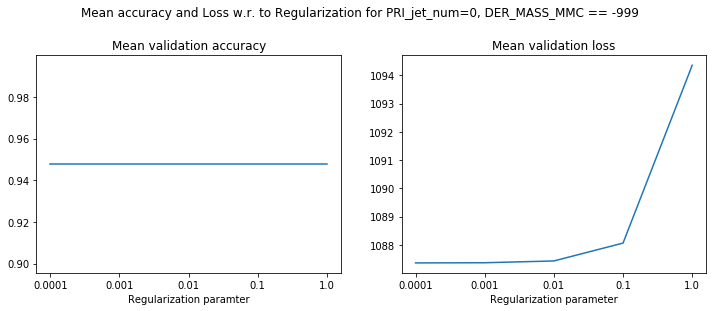

In [49]:
cross_validate_reg(tX_0_nm, y_0_nm, headers, 1e-5, degree_0_nm, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=0, DER_MASS_MMC == -999")

In [149]:
w_0_nm, matrix_0_nm = train_model(tX_0_nm, y_0_nm, headers, degree_0_nm, 0.9, 1300, 1e-5, 1e-4)

The 17 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet']

Performing polynomial expansion up to degree 3
Matrix has now 17 features
Gradient Descent(0/1299): loss=62238.52357343209
Gradient Descent(100/1299): loss=4464.820075931193
Gradient Descent(200/1299): loss=4166.149934134747
Gradient Descent(300/1299): loss=4098.541524399806
Gradient Descent(400/1299): loss=4094.0950916612146
Gradient Descent(500/1299): loss=4090.2830756846724
Gradient Descent(600/1299): loss=4086.6962684106097
Gradient Descent(700/1299): loss=4086.3178724188883
Gradient Descent(800/1299): loss=4085.9727891509415
Gradient Descent(900/1299): loss=4085.629658813631
Gradient Descent(1000/1299): loss=4085.5923751334926
Gradien

### Category 1

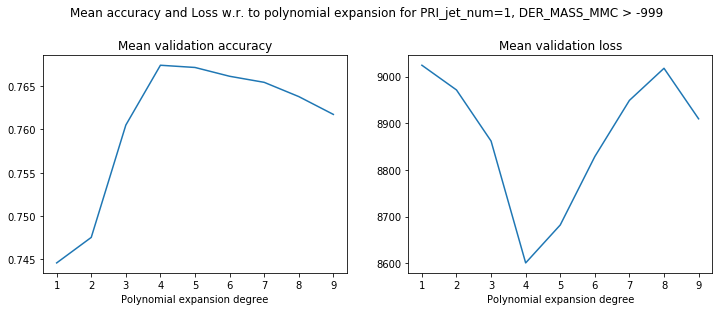

In [52]:
cross_validate_degrees(tX_1, y_1, headers, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [53]:
degree_1 = 4

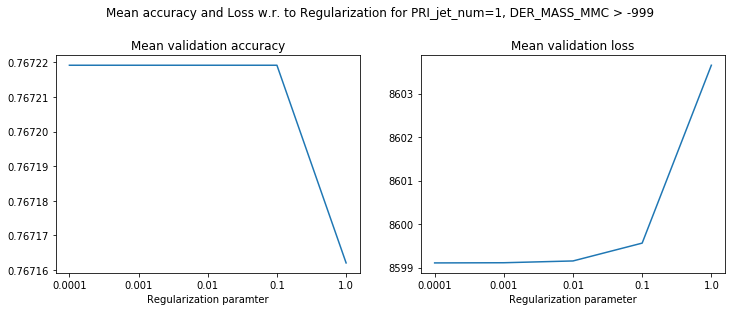

In [54]:
cross_validate_reg(tX_1, y_1, headers, 1e-5, degree_1, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=1, DER_MASS_MMC > -999")

In [146]:
w_1, matrix_1 = train_model(tX_1, y_1, headers, degree_1, 0.9, 1000, 1e-5, 1e-1)

The 22 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet' 'PRI_jet_leading_pt' 'PRI_jet_leading_eta'
 'PRI_jet_leading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 4
Matrix has now 22 features
Gradient Descent(0/999): loss=118151.96972786252
Gradient Descent(100/999): loss=36647.40657175926
Gradient Descent(200/999): loss=36647.40390143913
Gradient Descent(300/999): loss=36647.40390143419
Gradient Descent(400/999): loss=36647.40390143419


KeyboardInterrupt: 

### Category 1, no mass defined

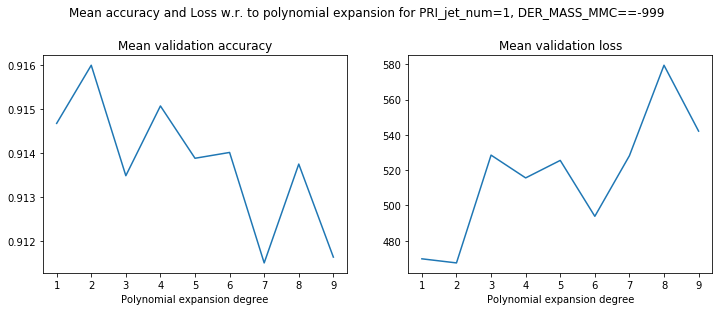

In [59]:
cross_validate_degrees(tX_1_nm, y_1_nm, headers, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC==-999")

In [60]:
degree_1_nm = 2

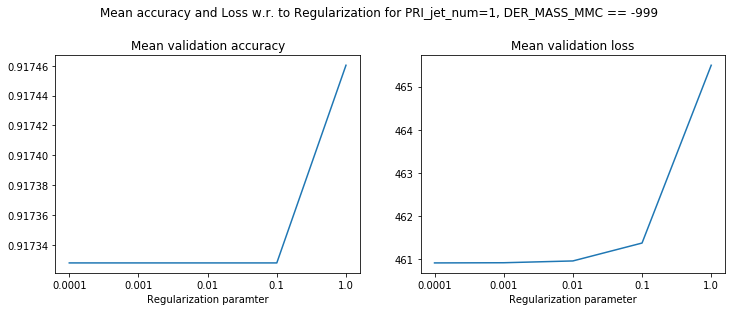

In [61]:
cross_validate_reg(tX_1_nm, y_1_nm, headers, 1e-5, degree_1_nm, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=1, DER_MASS_MMC == -999")

In [147]:
w_1_nm, matrix_1_nm = train_model(tX_1_nm, y_1_nm, headers, degree_1_nm, 0.9, 1000, 1e-4, 1e-1)

The 21 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet' 'PRI_jet_leading_pt' 'PRI_jet_leading_eta'
 'PRI_jet_leading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 2
Matrix has now 21 features
Gradient Descent(0/999): loss=16216.724213758242
Gradient Descent(100/999): loss=1717.3987240569566
Gradient Descent(200/999): loss=1716.0627026442482
Gradient Descent(300/999): loss=1716.0403750234839
Gradient Descent(400/999): loss=1716.0402188959051
Gradient Descent(500/999): loss=1716.0401234849362
Gradient Descent(600/999): loss=1716.040058664606
Gradient Descent(700/999): loss=1716.0400530013671
Gradient Descent(800/999): loss=1716.0400480116523
Gradient Descent(900/999): loss=17

### Category 2

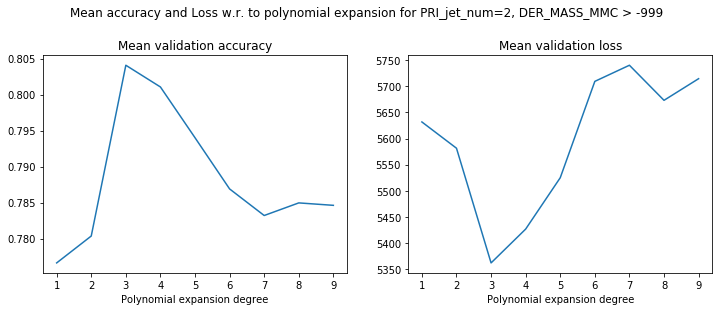

In [64]:
cross_validate_degrees(tX_2, y_2, headers, 1e-4, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=2, DER_MASS_MMC > -999")

In [65]:
degree_2 = 3

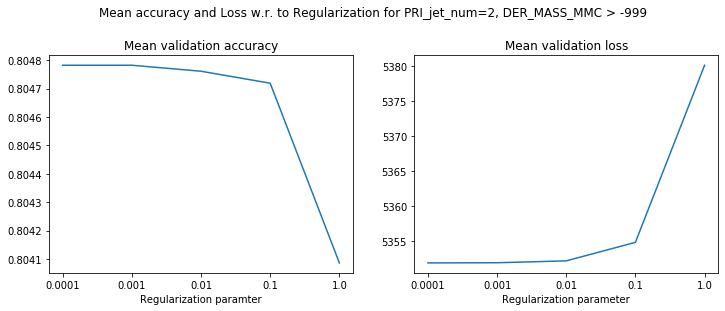

In [66]:
cross_validate_reg(tX_2, y_2, headers, 1e-4, degree_2, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=2, DER_MASS_MMC > -999")

In [125]:
w_2, matrix_2 = train_model(tX_2, y_2, headers, degree_2, 0.9, 1000, 1e-4, 0)

The 29 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 3
Matrix has now 203 features
Gradient Descent(0/999): loss=102314.6344448381
Gradient Descent(100/999): loss=19096.35396933439
Gradient Descent(200/999): loss=18898.344759116902
Gradient Descent(300/999): loss=18829.48679080024
Gradient Descent(400/999): loss=18825.017257433567
Gradient Descent(500/999): loss=18821.251735123544
Gradient

### Category 2, no mass defined

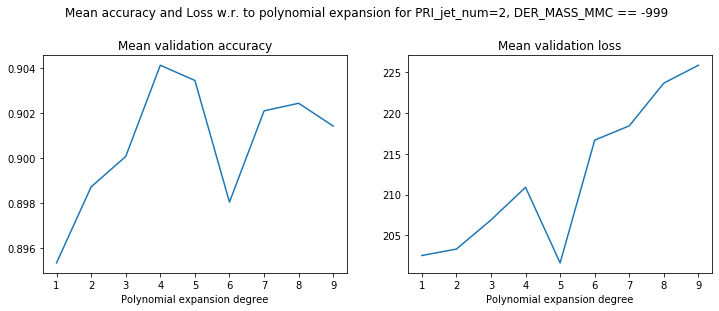

In [73]:
cross_validate_degrees(tX_2_nm, y_2_nm, headers, 1e-4, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=2, DER_MASS_MMC == -999")

In [80]:
degree_2_nm = 4

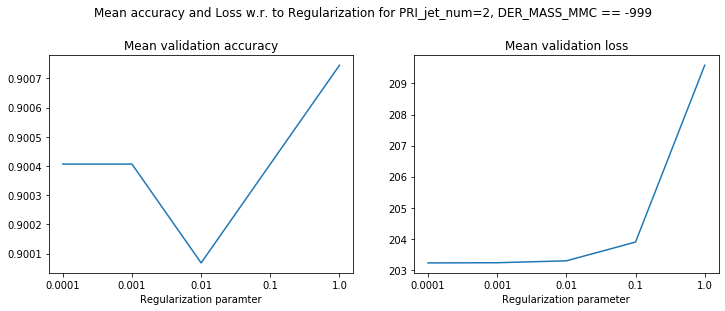

In [82]:
cross_validate_reg(tX_2_nm, y_2_nm, headers, 1e-4, degree_2_nm, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=2, DER_MASS_MMC == -999")

In [126]:
w_2_nm, matrix_2_nm = train_model(tX_2_nm, y_2_nm, headers, degree_2_nm, 0.9, 1000, 1e-4, 0)

The 28 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 4
Matrix has now 224 features
Gradient Descent(0/999): loss=8944.956659540914
Gradient Descent(100/999): loss=933.1081943328334
Gradient Descent(200/999): loss=719.3128983760591
Gradient Descent(300/999): loss=668.1087474959135
Gradient Descent(400/999): loss=666.0891054508159
Gradient Descent(500/999): loss=664.4210143521206
Gradient Descent(600/999):

### Category 3

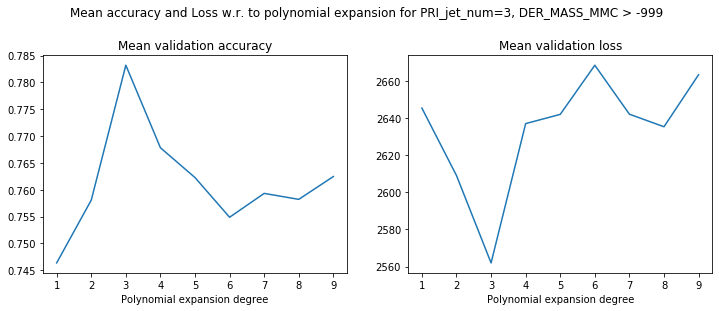

In [101]:
cross_validate_degrees(tX_3, y_3, headers, 1e-4, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=3, DER_MASS_MMC > -999")

In [102]:
degree_3 = 3

In [ ]:
cross_validate_reg(tX_3, y_3, headers, 1e-4, degree_3, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=3, DER_MASS_MMC > -999")

In [127]:
w_3, matrix_3 = train_model(tX_3, y_3, headers, degree_3, 0.9, 1500, 1e-3, 0)

The 29 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 3
Matrix has now 203 features
Gradient Descent(0/1499): loss=52718.80946433507
Gradient Descent(100/1499): loss=18575.621614286334
Gradient Descent(200/1499): loss=18204.71407897144
Gradient Descent(300/1499): loss=18081.77191205136
Gradient Descent(400/1499): loss=9362.253989587412
Gradient Descent(500/1499): loss=9312.339186403997
Grad

### Category 3, no mass defined

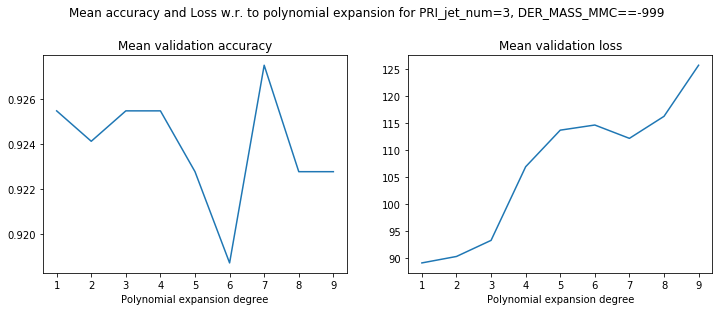

In [107]:
cross_validate_degrees(tX_3_nm, y_3_nm, headers, 1e-4,0,  np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=3, DER_MASS_MMC==-999")

In [108]:
degree_3_nm = 7

In [128]:
w_3_nm, matrix_3_nm = train_model(tX_3_nm, y_3_nm, headers, degree_3_nm, 0.9, 1000, 1e-1, 0)

The 28 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt']

Performing polynomial expansion up to degree 7
Matrix has now 308 features
Gradient Descent(0/999): loss=4429.827978877094
Gradient Descent(100/999): loss=2623.2631226333165
Gradient Descent(200/999): loss=1362.746672419399
Gradient Descent(300/999): loss=1583.623386741956
Gradient Descent(400/999): loss=248.23694964604493
Gradient Descent(500/999): loss=242.31145025986785
Gradient Descent(600/99

## Generate predictions and save ouput in csv format for submission:

In [116]:
from data_processing import prepare_for_testing

In [117]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [133]:
def predict_testset(x, h, degrees, w, proj_mat):
    x,_ = enhance_features(x, h, degrees, proj_matrix=proj_mat, print_=False)
    x = prepare_for_testing(x)
    y_pred = predict_labels(w, x)
    return y_pred

In [134]:
tX_0_test, ids_0, tX_0_nm_test, ids_0_nm, tX_1_test, ids_1, tX_1_nm_test, ids_1_nm, tX_2_test, ids_2, tX_2_nm_test, ids_2_nm, tX_3_test, ids_3, tX_3_nm_test, ids_3_nm = split_dataset(tX_test, ids_test, jet_col=22, mass_col=0) # Split into each category

In [135]:
y_pred_0 = predict_testset(tX_0_test, headers, degree_0, w_0, matrix_0)
y_pred_0_nm = predict_testset(tX_0_nm_test, headers, degree_0_nm, w_0_nm, matrix_0_nm)

In [136]:
y_pred_1 = predict_testset(tX_1_test, headers, degree_1, w_1, matrix_1)
y_pred_1_nm = predict_testset(tX_1_nm_test, headers, degree_1_nm, w_1_nm, matrix_1_nm)

In [137]:
y_pred_2 = predict_testset(tX_2_test, headers, degree_2, w_2, matrix_2)
y_pred_2_nm = predict_testset(tX_2_nm_test, headers, degree_2_nm, w_2_nm, matrix_2_nm)

In [138]:
y_pred_3 = predict_testset(tX_3_test, headers, degree_3, w_3, matrix_3)
y_pred_3_nm = predict_testset(tX_3_nm_test, headers, degree_3_nm, w_3_nm, matrix_3_nm)

In [139]:
ids_test = np.concatenate([ids_0, ids_0_nm, ids_1, ids_1_nm, ids_2, ids_2_nm, ids_3, ids_3_nm])
y_pred = np.concatenate([y_pred_0, y_pred_0_nm, y_pred_1, y_pred_1_nm, y_pred_2, y_pred_2_nm, y_pred_3, y_pred_3_nm])

In [140]:
y_pred.shape[0] == tX_test.shape[0]

True

In [141]:
OUTPUT_PATH = 'test.csv' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights_ridge, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)